
# Comparison of Probabilistic PCA, Linear VAE, and Convolutional VAE

This script implements and compares three related dimensionality reduction and generative models using the MNIST dataset:
1.  **Probabilistic Principal Component Analysis (PPCA)**: A classical linear latent variable model with an analytical solution.
2.  **Convolutional Variational Autoencoder (Convolutional VAE)**: A more powerful VAE using Convolutional Neural Networks (CNNs) suitable for image data.


In [2]:
# # Standard Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, RMSprop, Adagrad
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
# Set device for PyTorch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Constant for log likelihood calculation
_LOG_2PI = np.log(2 * np.pi)

## 1. Dataset Preparation (MNIST)

We load the MNIST dataset. It consists of 60,000 training images of handwritten digits (0-9), each of size 28x28 pixels.
- For PPCA, we flatten the images into 784-dimensional vectors.
- For Convolutional VAE, we keep the 2D structure (1x28x28).


In [6]:
BATCH_SIZE = 100 # Batch size for training VAEs
DATA_DIR = './mnist_data' # Directory to store MNIST data

# Transformation: Convert images to tensors and normalize pixel values to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the training dataset
train_dataset = datasets.MNIST(
    DATA_DIR, train=True, download=True, transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
# Add test loader for model evaluation and visualization
test_dataset = datasets.MNIST(
    root=DATA_DIR, train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)
# Load a subset of data for PPCA  demonstration
# Note: PPCA analysis often uses the covariance of the *entire* dataset
# or a large subset. Here we use a smaller subset for faster demonstration.
NUM_SAMPLES_LINEAR = 5000
subset_indices = np.random.choice(len(train_dataset), NUM_SAMPLES_LINEAR, replace=False)
subset_data = torch.utils.data.Subset(train_dataset, subset_indices)
linear_data_loader = torch.utils.data.DataLoader(subset_data, batch_size=NUM_SAMPLES_LINEAR, shuffle=False)

# Get a batch of flattened data for PPCA/Linear VAE
mnist_data_linear, _ = next(iter(linear_data_loader))
mnist_data_linear_np = mnist_data_linear.view(NUM_SAMPLES_LINEAR, -1).numpy() # Shape: (NUM_SAMPLES_LINEAR, 784)

print(f"MNIST data loaded.")
print(f"Shape for Linear Models (subset): {mnist_data_linear_np.shape}")
print(f"Data loader batch size for Conv VAE: {BATCH_SIZE}")

MNIST data loaded.
Shape for Linear Models (subset): (5000, 784)
Data loader batch size for Conv VAE: 100


## 2. Probabilistic PCA (PPCA)
**Concept**: PPCA models observed data $ \mathbf{x} \in \mathbb{R}^D $ as a linear transformation of a lower-dimensional latent variable $ \mathbf{z} \in \mathbb{R}^d $ (where $ d < D $) plus Gaussian noise.
- Prior: $ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I}) $
- Likelihood (Decoder): $ p(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{Wz} + \boldsymbol{\mu}, \sigma^2 \mathbf{I}) $
- Marginal Likelihood: $ p(\mathbf{x}) = \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \mathbf{WW}^T + \sigma^2 \mathbf{I}) $

The parameters $ \mathbf{W} $, $ \boldsymbol{\mu} $, and $ \sigma^2 $ have closed-form Maximum Likelihood Estimates (MLE) based on the data covariance matrix.(same as assignment1)


In [7]:
def compute_ppca_mle(data, z_dim):
    """
    Compute the Probabilistic PCA Maximum Likelihood Estimates.

    Args:
        data (np.ndarray): The input data matrix (N x D). N samples, D dimensions.
        z_dim (int): The desired latent dimensionality.

    Returns:
        tuple: (sigma_sq_mle, W_mle, mu_mle)
            - sigma_sq_mle (float): MLE of the noise variance.
            - W_mle (np.ndarray): MLE of the factor loading matrix (D x d).
            - mu_mle (np.ndarray): MLE of the data mean (D,).
    """
    N, D = data.shape
    if z_dim >= D:
        raise ValueError("Latent dimension (z_dim) must be smaller than data dimension (D).")

    mu_mle = data.mean(axis=0)
    data_centered = data - mu_mle
    covariance = np.cov(data_centered, rowvar=False) # (D x D)

    # Eigen decomposition of the covariance matrix
    # eigh is preferred for symmetric matrices like covariance matrices
    eigvals, eigvecs = np.linalg.eigh(covariance)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Estimate noise variance sigma^2
    # Average of the smallest D - z_dim eigenvalues
    sigma_sq_mle = np.mean(eigvals[z_dim:])

    # Estimate W
    # Ensure eigenvalues used for W are >= sigma_sq_mle (they should be if z_dim is chosen reasonably)
    active_eigvals = eigvals[:z_dim]
    if np.any(active_eigvals < sigma_sq_mle):
       print(f"Warning: Some top {z_dim} eigenvalues are smaller than estimated sigma^2_mle. Clamping them.")
       active_eigvals = np.maximum(active_eigvals, sigma_sq_mle)


    Lambda_d = np.diag(active_eigvals) # (d x d) diagonal matrix of top d eigenvalues
    U_d = eigvecs[:, :z_dim] # (D x d) matrix of corresponding eigenvectors

    # W_mle = U_d * (Lambda_d - sigma^2 * I)^(1/2) * R
    # R is an arbitrary rotation matrix (d x d). We can choose R = I.
    W_mle = U_d @ np.sqrt(Lambda_d - sigma_sq_mle * np.eye(z_dim)) # (D x d)

    return sigma_sq_mle, W_mle, mu_mle

def log_likelihood_ppca(data, W, mu, sigma_sq):
    """
    Compute the average log-likelihood of the data under the PPCA model.

    Args:
        data (np.ndarray): The input data matrix (N x D).
        W (np.ndarray): Factor loading matrix (D x d).
        mu (np.ndarray): Data mean (D,).
        sigma_sq (float): Noise variance.

    Returns:
        float: Average log-likelihood per data point.
    """
    N, D = data.shape
    d = W.shape[1]

    # Model covariance C = WW^T + sigma^2 * I
    C = W @ W.T + sigma_sq * np.eye(D)

    # Avoid numerical issues with determinant and inverse
    try:
        # Use Cholesky decomposition for stability and efficiency
        L = np.linalg.cholesky(C)
        log_det_C = 2 * np.sum(np.log(np.diag(L)))

        # Solve C^-1 * S efficiently using Cholesky factor
        # S is the sample covariance matrix: S = (1/N) * sum[(x_n - mu)(x_n - mu)^T]
        data_centered = data - mu
        sample_covariance = (data_centered.T @ data_centered) / N # (D x D)

        # Efficiently compute trace(C^-1 * S) = trace(L^-T * L^-1 * S)
        # Let Z = L^-1 * S. Then trace(L^-T * Z).
        # Let Y = L^-1 * data_centered^T. trace = (1/N) * trace(Y^T * Y)
        Y = np.linalg.solve(L, data_centered.T) # Solves LY = data_centered^T
        trace_term = np.sum(Y**2) / N

    except np.linalg.LinAlgError:
        print("Warning: Covariance matrix C might be ill-conditioned.")
        # Fallback to direct calculation (less stable)
        sign, log_det_C = np.linalg.slogdet(C)
        if sign <= 0:
            print("Error: Determinant is non-positive.")
            return -np.inf
        C_inv = np.linalg.inv(C)
        sample_covariance = np.cov(data, rowvar=False) # Recalculate just in case
        trace_term = np.trace(C_inv @ sample_covariance)


    # Log Likelihood formula for Gaussian: -N/2 * [D*log(2pi) + log|C| + trace(C^-1 * S)]
    loglik = -0.5 * (D * _LOG_2PI + log_det_C + trace_term)

    return loglik # Average log-likelihood per sample



--- Running PPCA with z_dim = 50 ---
PPCA MLE Results:
  Estimated sigma^2: 0.0124
  Shape of W_mle: (784, 50)
  Shape of mu_mle: (784,)
  Average Log-Likelihood (MLE): 512.7317


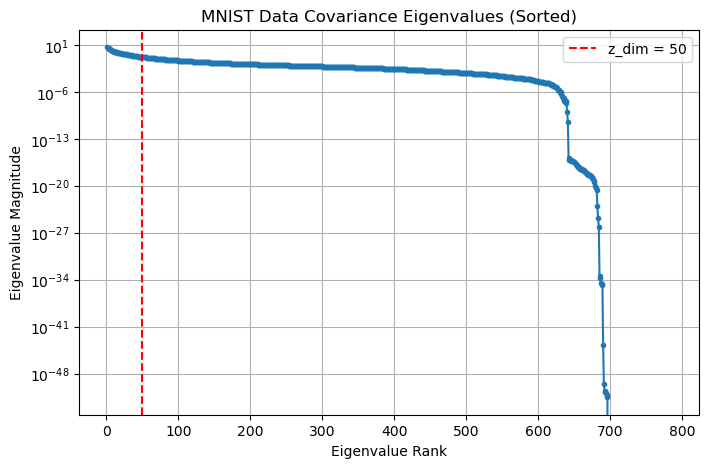

In [8]:
# --- PPCA Demonstration ---
Z_DIM_PPCA = 50 # Example latent dimension

print(f"\n--- Running PPCA with z_dim = {Z_DIM_PPCA} ---")

# Compute PPCA MLE parameters
sigma_sq_mle, W_mle, mu_mle = compute_ppca_mle(mnist_data_linear_np, Z_DIM_PPCA)

print(f"PPCA MLE Results:")
print(f"  Estimated sigma^2: {sigma_sq_mle:.4f}")
print(f"  Shape of W_mle: {W_mle.shape}")
print(f"  Shape of mu_mle: {mu_mle.shape}")

# Compute the log-likelihood of the data given the learned parameters
avg_log_lik_mle = log_likelihood_ppca(mnist_data_linear_np, W_mle, mu_mle, sigma_sq_mle)
print(f"  Average Log-Likelihood (MLE): {avg_log_lik_mle:.4f}")

# Visualize Eigenvalues of the data covariance
covariance = np.cov(mnist_data_linear_np, rowvar=False)
eigvals, _ = np.linalg.eigh(covariance)
eigvals = np.sort(eigvals)[::-1] # Sort descending

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigvals) + 1), eigvals, marker='.', linestyle='-')
plt.axvline(Z_DIM_PPCA, color='r', linestyle='--', label=f'z_dim = {Z_DIM_PPCA}')
plt.title('MNIST Data Covariance Eigenvalues (Sorted)')
plt.xlabel('Eigenvalue Rank')
plt.ylabel('Eigenvalue Magnitude')
plt.yscale('log') # Often helpful to see the smaller eigenvalues
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'ppca_eigenvalues.png'), dpi=300)

## 3. Convolutional VAE (Conv VAE)

**Concept**: This VAE uses Convolutional Neural Networks (CNNs) for both the encoder and decoder. This allows the model to capture spatial hierarchies and local patterns present in image data, leading to much better performance for tasks like image reconstruction and generation compared to linear models.
- **Encoder** $ q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) $: A CNN takes the input image $ \mathbf{x} $ and outputs the parameters $ \boldsymbol{\mu}_{\phi}(\mathbf{x}) $ and $ \boldsymbol{\sigma}^2_{\phi}(\mathbf{x}) $ of the Gaussian posterior approximation $ \mathcal{N}(\mathbf{z} | \boldsymbol{\mu}_{\phi}(\mathbf{x}), \mathrm{diag}(\boldsymbol{\sigma}^2_{\phi}(\mathbf{x}))) $.
- **Decoder** $ p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}) $: A "deconvolutional" or transposed CNN takes a latent sample $ \mathbf{z} $ and outputs the parameters of the likelihood distribution for the image $ \mathbf{x} $. For MNIST, this is often modeled as a product of independent Bernoulli distributions for each pixel, where the decoder outputs the probability parameter $ y_i $ for each pixel $ x_i $. $ p(\mathbf{x}|\mathbf{z}) = \prod_i y_i^{x_i} (1-y_i)^{1-x_i} $. The output layer uses a Sigmoid activation to ensure probabilities are in [0, 1].
- **Optimization**: Maximize ELBO = $ \mathbb{E}_{q(\mathbf{z}|\mathbf{x})}[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})] - \mathrm{KL}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) || p(\mathbf{z})) $. The expectation $ \mathbb{E}_{q(\mathbf{z}|\mathbf{x})}[\log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})] $ is now estimated using Monte Carlo sampling via the **reparameterization trick**: sample $ \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) $ and set $ \mathbf{z} = \boldsymbol{\mu}_{\phi}(\mathbf{x}) + \boldsymbol{\sigma}_{\phi}(\mathbf{x}) \odot \boldsymbol{\epsilon} $.


In [9]:
class ConvEncoder(nn.Module):
    """Convolutional Encoder Network."""
    def __init__(self, latent_dim=10):
        super().__init__()
        self.latent_dim = latent_dim

        # Input shape: (N, 1, 28, 28) for MNIST
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2
            ), # -> (N, 16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # -> (N, 16, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
            ), # -> (N, 32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # -> (N, 32, 7, 7)
        )
        # Flattened size: 32 * 7 * 7 = 1568
        self.fc_mu = nn.Linear(32 * 7 * 7, latent_dim) # Output layer for mean (mu)
        self.fc_logvar = nn.Linear(32 * 7 * 7, latent_dim) # Output layer for log variance (log sigma^2)

    def forward(self, x):
        """
        Encodes the input image x into latent distribution parameters.

        Args:
            x (torch.Tensor): Input image tensor (N, 1, 28, 28).

        Returns:
            tuple: (mu, logvar)
                - mu (torch.Tensor): Latent mean (N, latent_dim).
                - logvar (torch.Tensor): Latent log variance (N, latent_dim).
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x) # Output log(sigma^2) directly
        return mu, logvar

class ConvDecoder(nn.Module):
    """Convolutional Decoder Network."""
    def __init__(self, latent_dim=10):
        super().__init__()
        self.latent_dim = latent_dim

        # Input: latent vector z (N, latent_dim)
        self.fc = nn.Linear(latent_dim, 32 * 7 * 7) # Project z back to the spatial dimension before conv layers

        # Reshape -> (N, 32, 7, 7)
        self.deconv1 = nn.Sequential(
            # Using Upsample + Conv2d instead of ConvTranspose2d avoids checkerboard artifacts
            nn.Upsample(scale_factor=2, mode='nearest'), # -> (N, 32, 14, 14)
            nn.Conv2d(
                in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2
            ), # -> (N, 16, 14, 14)
            nn.ReLU(),
        )
        self.deconv2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), # -> (N, 16, 28, 28)
            nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2
            ), # -> (N, 16, 28, 28)
             nn.ReLU(),
        )
        # Final layer to produce the image (1 channel)
        self.deconv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1
            ), # -> (N, 1, 28, 28)
            nn.Sigmoid() # Output pixel probabilities (Bernoulli parameters) in [0, 1]
        )

    def forward(self, z):
        """
        Decodes the latent vector z into an image.

        Args:
            z (torch.Tensor): Latent vector (N, latent_dim).

        Returns:
            torch.Tensor: Reconstructed image probabilities (N, 1, 28, 28).
        """
        z = self.fc(z)
        z = z.view(z.size(0), 32, 7, 7) # Reshape to (N, C, H, W)
        z = self.deconv1(z)
        z = self.deconv2(z)
        x_recon_probs = self.deconv3(z) # Output probabilities
        return x_recon_probs

# Combined VAE Model (optional, can also use Encoder/Decoder separately)
class ConvolutionalVAE(nn.Module):
    """Combines Encoder and Decoder."""
    def __init__(self, latent_dim=10):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        """Applies the reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample from standard normal
        return mu + eps * std

    def forward(self, x):
        """Full forward pass: encode, reparameterize, decode."""
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon_probs = self.decoder(z)
        return x_recon_probs, mu, logvar

# Loss function for VAE
def vae_loss_function(x_recon_probs, x, mu, logvar):
    """
    Calculates the VAE loss (-ELBO).

    Args:
        x_recon_probs (torch.Tensor): Decoder output (pixel probabilities) (N, 1, 28, 28).
        x (torch.Tensor): Original input image (N, 1, 28, 28).
        mu (torch.Tensor): Latent mean (N, latent_dim).
        logvar (torch.Tensor): Latent log variance (N, latent_dim).

    Returns:
        torch.Tensor: Scalar loss value (-ELBO).
    """
    # Reconstruction Loss (Binary Cross Entropy for Bernoulli likelihood)
    # Sum over pixels (dims 1, 2, 3), then average over batch (dim 0)
    BCE = F.binary_cross_entropy(x_recon_probs, x, reduction='sum') / x.size(0)
    # Alternatively, using the formula from the original script:
    # BCE_manual = -torch.sum(x * torch.log(x_recon_probs + 1e-8) + (1 - x) * torch.log(1 - x_recon_probs + 1e-8), dim=[1, 2, 3])
    # BCE = torch.mean(BCE_manual)


    # KL Divergence (between q(z|x) and p(z)=N(0,I))
    # D_KL( N(mu, sigma^2) || N(0, I) ) = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(logvar)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD = KLD / x.size(0) # Average over batch

    # Total Loss (-ELBO) = Reconstruction Loss + KL Divergence
    return BCE + KLD



--- Running Convolutional VAE with z_dim = 10 ---
Training Convolutional VAE for 5 epochs...
Epoch: 1 [0/60000 (0%)]	Loss (-ELBO): 571.5599
Epoch: 1 [20000/60000 (33%)]	Loss (-ELBO): 146.3600
Epoch: 1 [40000/60000 (67%)]	Loss (-ELBO): 124.6901
====> Epoch: 1 Average loss: 152.3158
Epoch: 2 [0/60000 (0%)]	Loss (-ELBO): 117.8682
Epoch: 2 [20000/60000 (33%)]	Loss (-ELBO): 127.5969
Epoch: 2 [40000/60000 (67%)]	Loss (-ELBO): 114.8212
====> Epoch: 2 Average loss: 116.3846
Epoch: 3 [0/60000 (0%)]	Loss (-ELBO): 119.1487
Epoch: 3 [20000/60000 (33%)]	Loss (-ELBO): 109.5999
Epoch: 3 [40000/60000 (67%)]	Loss (-ELBO): 108.7006
====> Epoch: 3 Average loss: 112.3390
Epoch: 4 [0/60000 (0%)]	Loss (-ELBO): 112.2004
Epoch: 4 [20000/60000 (33%)]	Loss (-ELBO): 108.1737
Epoch: 4 [40000/60000 (67%)]	Loss (-ELBO): 108.6449
====> Epoch: 4 Average loss: 110.3482
Epoch: 5 [0/60000 (0%)]	Loss (-ELBO): 110.0916
Epoch: 5 [20000/60000 (33%)]	Loss (-ELBO): 107.5274
Epoch: 5 [40000/60000 (67%)]	Loss (-ELBO): 104.7061

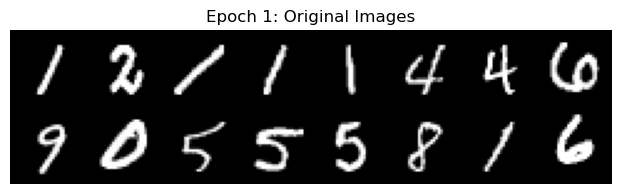

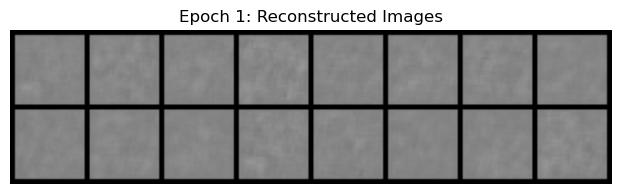

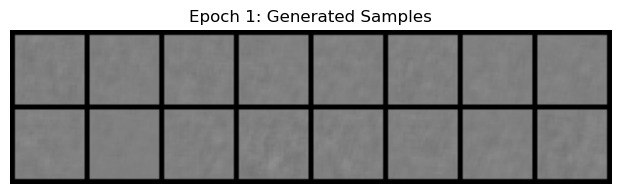

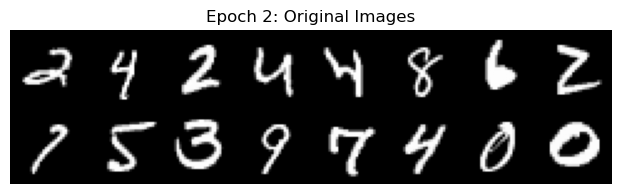

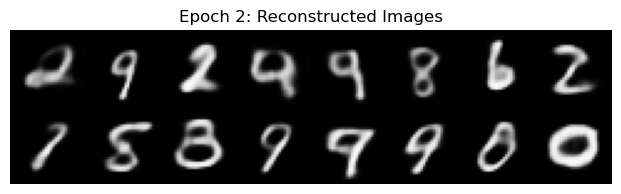

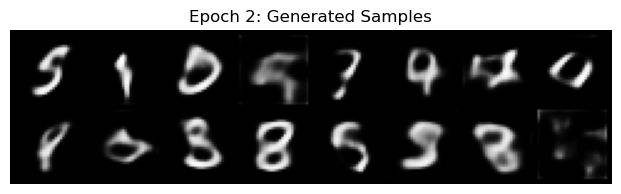

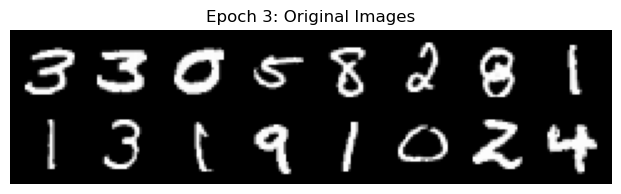

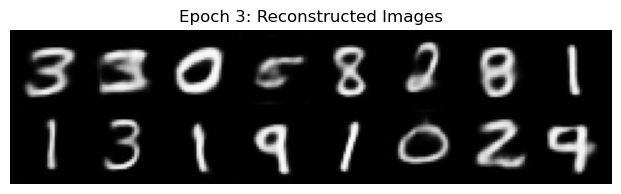

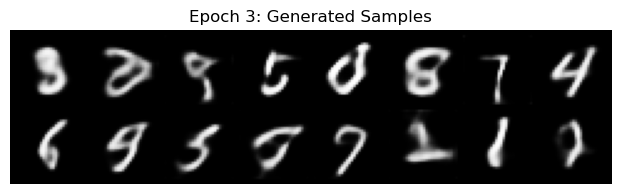

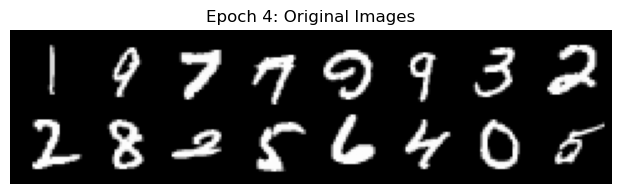

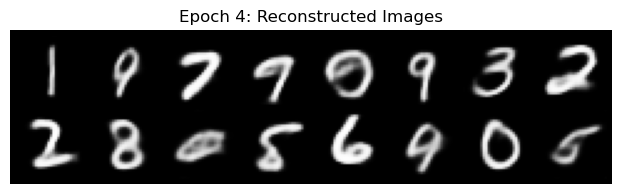

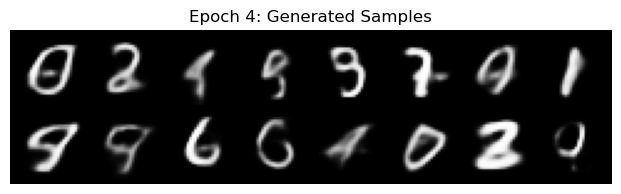

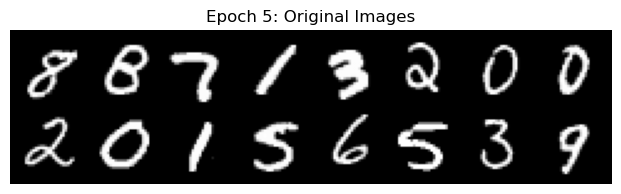

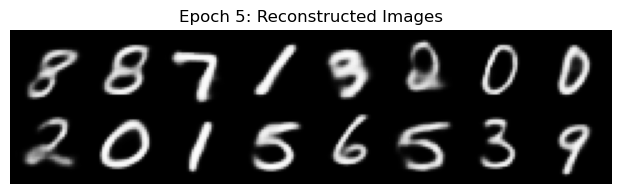

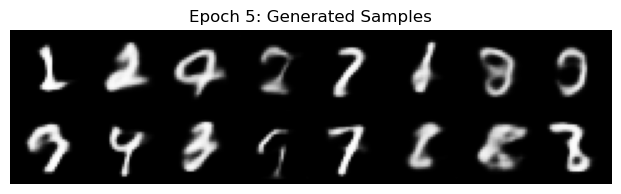

In [10]:
# --- Convolutional VAE Demonstration ---
LATENT_DIM_CONV = 10 # Example latent dimension for Conv VAE
LEARNING_RATE_CONV = 0.001
EPOCHS_CONV = 5 # Train for fewer epochs for quick demo

print(f"\n--- Running Convolutional VAE with z_dim = {LATENT_DIM_CONV} ---")

# Model Instantiation
conv_vae = ConvolutionalVAE(latent_dim=LATENT_DIM_CONV).to(DEVICE)

# Optimizer
optimizer_conv = Adam(conv_vae.parameters(), lr=LEARNING_RATE_CONV)

# Training Loop (adapted from vaepytorch2.py)
elbos_conv = []
print(f"Training Convolutional VAE for {EPOCHS_CONV} epochs...")

def train_conv_vae(epoch):
    conv_vae.train() # Set model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE) # Shape: (BATCH_SIZE, 1, 28, 28)
        optimizer_conv.zero_grad()

        # Forward pass
        recon_batch_probs, mu, logvar = conv_vae(data)

        # Calculate loss
        loss = vae_loss_function(recon_batch_probs, data, mu, logvar)

        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optimizer_conv.step()

        current_elbo = -loss.item()
        elbos_conv.append(current_elbo) # Store ELBO per step

        if batch_idx % 200 == 0: # Print progress every 200 batches
            print(f'Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss (-ELBO): {loss.item():.4f}')

            # --- Visualization during training ---
            if batch_idx == 0 : # Only plot for the first batch of the epoch
                 with torch.no_grad():
                    # 1. Original Images
                    plt.figure(figsize=(8, 2))
                    plt.axis("off")
                    plt.title(f"Epoch {epoch+1}: Original Images")
                    grid_img_orig = vutils.make_grid(data[:16].cpu(), padding=2, normalize=False, nrow=8)
                    plt.imshow(np.transpose(grid_img_orig, (1, 2, 0)), cmap='gray')
                    plt.savefig(os.path.join(output_dir, f'conv_vae_epoch_{epoch+1}_original_images.png'), dpi=300)

                    # 2. Reconstructed Images
                    plt.figure(figsize=(8, 2))
                    plt.axis("off")
                    plt.title(f"Epoch {epoch+1}: Reconstructed Images")
                    grid_img_recon = vutils.make_grid(recon_batch_probs[:16].cpu(), padding=2, normalize=False, nrow=8)
                    plt.imshow(np.transpose(grid_img_recon, (1, 2, 0)), cmap='gray')
                    plt.savefig(os.path.join(output_dir, f'conv_vae_epoch_{epoch+1}_reconstructed_images.png'), dpi=300)

                    # 3. Generated Samples from Prior
                    # Sample z ~ N(0, I)
                    z_sample = torch.randn(16, LATENT_DIM_CONV).to(DEVICE)
                    generated_probs = conv_vae.decoder(z_sample)
                    plt.figure(figsize=(8, 2))
                    plt.axis("off")
                    plt.title(f"Epoch {epoch+1}: Generated Samples")
                    grid_img_gen = vutils.make_grid(generated_probs.cpu(), padding=2, normalize=False, nrow=8)
                    plt.imshow(np.transpose(grid_img_gen, (1, 2, 0)), cmap='gray')
                    plt.savefig(os.path.join(output_dir, f'conv_vae_epoch_{epoch+1}_generated_samples.png'), dpi=300)


    avg_train_loss = train_loss / len(train_loader.dataset) * BATCH_SIZE # Adjust for averaging
    print(f'====> Epoch: {epoch+1} Average loss: {avg_train_loss:.4f}')


# Train the model
for epoch in range(EPOCHS_CONV):
    train_conv_vae(epoch)

print("Convolutional VAE training finished.")


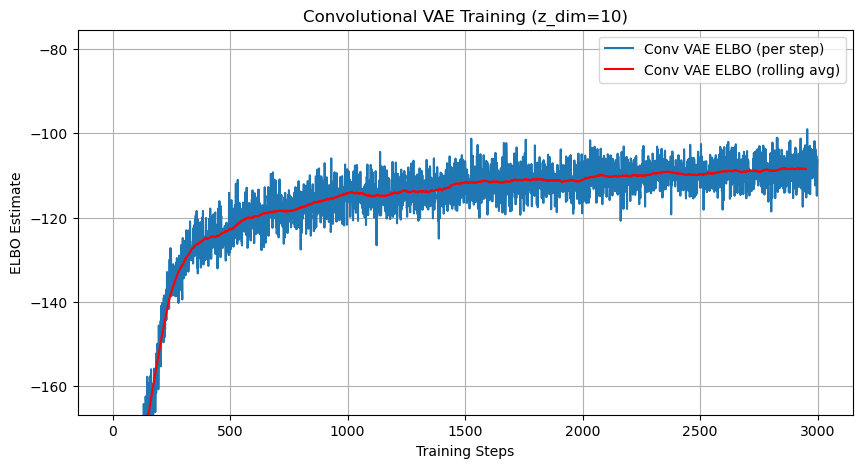

In [11]:
# Plot ELBO curve (per step)
plt.figure(figsize=(10, 5))
plt.plot(elbos_conv, label='Conv VAE ELBO (per step)')
plt.title(f'Convolutional VAE Training (z_dim={LATENT_DIM_CONV})')
plt.xlabel('Training Steps')
plt.ylabel('ELBO Estimate')
# Add rolling average to smooth the curve
rolling_avg = np.convolve(elbos_conv, np.ones(100)/100, mode='valid')
plt.plot(np.arange(len(rolling_avg)) + 50, rolling_avg, label='Conv VAE ELBO (rolling avg)', color='red')
plt.legend()
plt.grid(True)
plt.ylim(bottom=np.percentile(elbos_conv, 5)) # Adjust y-limit to focus on later stage
plt.savefig(os.path.join(output_dir, 'conv_vae_elbo.png'), dpi=300  )

## 6. Visual Comparison of Reconstructions and Samples

Here we visually compare:
1. Original images
2. Reconstructed images from each model
3. Generated samples from each model


--- Visual Comparison of PPCA and Conv VAE ---


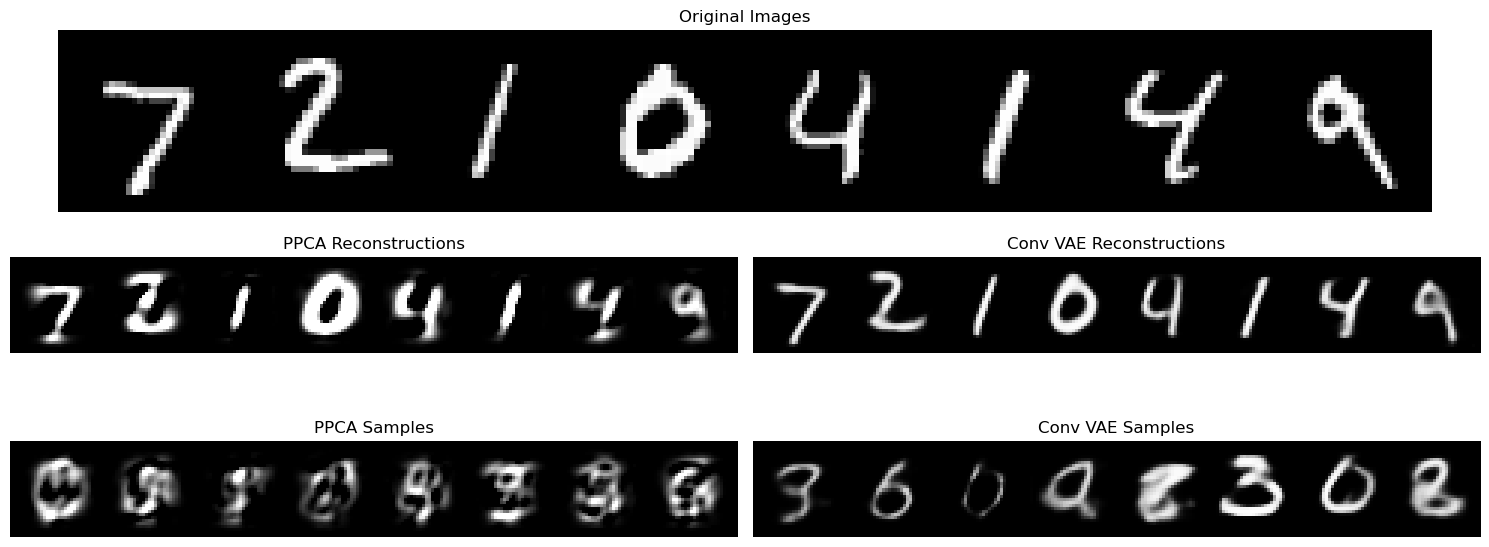

Visual comparison complete. Output files saved to the 'output' directory.


In [12]:
# Set up the comparison figure
print("\n--- Visual Comparison of PPCA and Conv VAE ---")

# Sample a small batch of test images for visualization
test_batch, _ = next(iter(test_loader))
test_images = test_batch[:8].to(DEVICE)  # Take 8 images for comparison
test_images_flat = test_images.view(test_images.size(0), -1)

# Create a figure for comparison
plt.figure(figsize=(15, 6))

# Row 1: Original Images
plt.subplot(3, 1, 1)
plt.axis("off")
plt.title("Original Images")
orig_grid = vutils.make_grid(test_images.cpu(), padding=2, normalize=False, nrow=8)
plt.imshow(np.transpose(orig_grid, (1, 2, 0)), cmap='gray')

# --- PPCA Reconstruction and Sampling ---
# Function to reconstruct images using PPCA
def ppca_reconstruct(data, W, mu):
    """Reconstruct images using PPCA model parameters."""
    # Center the data
    data_centered = data - mu
    
    # Project to latent space (posterior mean E[z|x])
    # For PPCA without sigma_sq parameter, we'll just do direct matrix multiplication
    # This is not the optimal projection but works for visualization
    z = data_centered @ W  # Shape: (n_samples, z_dim)
    
    # Reconstruct: x_recon = z @ W.T + mu
    x_recon = z @ W.T + mu
    
    # Clip values to valid pixel range [0, 1]
    x_recon = np.clip(x_recon, 0, 1)
    return x_recon

# Function to sample from PPCA model
def ppca_sample(n_samples, W, mu, sigma_sq):
    """Generate samples from PPCA model."""
    z_dim = W.shape[1]
    
    # Sample z ~ N(0, I)
    z = np.random.normal(0, 1, size=(n_samples, z_dim))
    
    # Generate x = W @ z + mu + noise
    x_mean = z @ W.T + mu
    
    # Add noise if needed: x = x_mean + N(0, sigma^2 * I)
    # noise = np.random.normal(0, np.sqrt(sigma_sq), size=(n_samples, W.shape[0]))
    # x_sample = x_mean + noise
    
    # For better visualization, let's skip the noise:
    x_sample = x_mean
    
    # Clip values to valid pixel range [0, 1]
    x_sample = np.clip(x_sample, 0, 1)
    return x_sample

# Compute PPCA reconstructions
test_images_np = test_images_flat.cpu().numpy()
ppca_reconstructions = ppca_reconstruct(test_images_np, W_mle, mu_mle)
ppca_reconstructions_tensor = torch.tensor(ppca_reconstructions).float().view(-1, 1, 28, 28)

# Sample from PPCA model
ppca_samples = ppca_sample(8, W_mle, mu_mle, sigma_sq_mle)
ppca_samples_tensor = torch.tensor(ppca_samples).float().view(-1, 1, 28, 28)

# --- Conv VAE Reconstruction and Sampling ---
conv_vae.eval()  # Set to evaluation mode
with torch.no_grad():
    # Reconstruction
    conv_mu, conv_logvar = conv_vae.encoder(test_images)
    conv_z = conv_vae.reparameterize(conv_mu, conv_logvar)
    conv_recon = conv_vae.decoder(conv_z).cpu()
    
    # Sampling
    conv_z_sample = torch.randn(8, LATENT_DIM_CONV).to(DEVICE)
    conv_samples = conv_vae.decoder(conv_z_sample).cpu()

# Row 2: Reconstructions
plt.subplot(3, 2, 3)
plt.axis("off")
plt.title("PPCA Reconstructions")
ppca_recon_grid = vutils.make_grid(ppca_reconstructions_tensor, padding=2, normalize=False, nrow=8)
plt.imshow(np.transpose(ppca_recon_grid, (1, 2, 0)), cmap='gray')

plt.subplot(3, 2, 4)
plt.axis("off")
plt.title("Conv VAE Reconstructions")
conv_recon_grid = vutils.make_grid(conv_recon, padding=2, normalize=False, nrow=8)
plt.imshow(np.transpose(conv_recon_grid, (1, 2, 0)), cmap='gray')

# Row 3: Generated samples
plt.subplot(3, 2, 5)
plt.axis("off")
plt.title("PPCA Samples")
ppca_samples_grid = vutils.make_grid(ppca_samples_tensor, padding=2, normalize=False, nrow=8)
plt.imshow(np.transpose(ppca_samples_grid, (1, 2, 0)), cmap='gray')

plt.subplot(3, 2, 6)
plt.axis("off")
plt.title("Conv VAE Samples")
conv_samples_grid = vutils.make_grid(conv_samples, padding=2, normalize=False, nrow=8)
plt.imshow(np.transpose(conv_samples_grid, (1, 2, 0)), cmap='gray')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'model_comparison_visuals.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Visual comparison complete. Output files saved to the 'output' directory.")


# %%



